# Introduction

In this project, you will build a neural network of your own design to evaluate the CIFAR-10 dataset.

To meet the requirements for this project, you will need to achieve an accuracy greater than 45%. 
If you want to beat Detectocorp's algorithm, you'll need to achieve an accuracy greater than 70%. 
(Beating Detectocorp's algorithm is not a requirement for passing this project, but you're encouraged to try!)

Some of the benchmark results on CIFAR-10 include:

78.9% Accuracy | [Deep Belief Networks; Krizhevsky, 2010](https://www.cs.toronto.edu/~kriz/conv-cifar10-aug2010.pdf)

90.6% Accuracy | [Maxout Networks; Goodfellow et al., 2013](https://arxiv.org/pdf/1302.4389.pdf)

96.0% Accuracy | [Wide Residual Networks; Zagoruyko et al., 2016](https://arxiv.org/pdf/1605.07146.pdf)

99.0% Accuracy | [GPipe; Huang et al., 2018](https://arxiv.org/pdf/1811.06965.pdf)

98.5% Accuracy | [Rethinking Recurrent Neural Networks and other Improvements for ImageClassification; Nguyen et al., 2020](https://arxiv.org/pdf/2007.15161.pdf)

Research with this dataset is ongoing. Notably, many of these networks are quite large and quite expensive to train. 

## Imports

In [1]:
## This cell contains the essential imports you will need – DO NOT CHANGE THE CONTENTS! ##
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from torchvision import datasets, models

## Load the Dataset

Specify your transforms as a list first.
The transforms module is already loaded as `transforms`.

CIFAR-10 is fortunately included in the torchvision module.
Then, you can create your dataset using the `CIFAR10` object from `torchvision.datasets` ([the documentation is available here](https://pytorch.org/docs/stable/torchvision/datasets.html#cifar)).
Make sure to specify `download=True`! 

Once your dataset is created, you'll also need to define a `DataLoader` from the `torch.utils.data` module for both the train and the test set.

In [2]:
# Define transforms
## YOUR CODE HERE ##
# create 3 tranforms which correspondent with train, validate and test set
train_transforms = transforms.Compose([transforms.RandomRotation(45),
                                      transforms.RandomResizedCrop(224),
                                      transforms.RandomHorizontalFlip(),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406],
                                                           [0.229, 0.224, 0.225])])

test_transforms = transforms.Compose([
                                    # transforms.Resize(256),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406],
                                                           [0.229, 0.224, 0.225])])
    

# Create training set and define training dataloader
## YOUR CODE HERE ##
train_dataset = torchvision.datasets.CIFAR10(root='./data', 
                                          train=True,
                                          transform=train_transforms, 
                                          download=True)
# split train_dataset to train_data and validate_data
train_data_size = int(0.8 * len(train_dataset))
valid_data_size = len(train_dataset) - train_data_size
train_data, valid_data = torch.utils.data.dataset.random_split(train_dataset, 
                                                    [train_data_size, valid_data_size])

# define train loader and validate loader
train_loader = torch.utils.data.DataLoader(train_data, batch_size=32, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid_data, batch_size=32, shuffle=False)

# Create test set and define test dataloader
## YOUR CODE HERE ##
test_data = torchvision.datasets.CIFAR10(root='./data', 
                                          train=False,
                                          transform=test_transforms, 
                                          download=True)
test_loader = torch.utils.data.DataLoader(train_data, batch_size=32, shuffle=True)

print("dataset size: {}".format(len(train_dataset)))
print("train data size: {}".format(len(train_data)))
print("validate data size: {}".format(len(valid_data)))
print("test data size: {}".format(len(test_data)))


# The 10 classes in the dataset
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified
dataset size: 50000
train data size: 40000
validate data size: 10000
test data size: 10000


## Explore the Dataset
Using matplotlib, numpy, and torch, explore the dimensions of your data.

You can view images using the `show5` function defined below – it takes a data loader as an argument.
Remember that normalized images will look really weird to you! You may want to try changing your transforms to view images.
Typically using no transforms other than `toTensor()` works well for viewing – but not as well for training your network.
If `show5` doesn't work, go back and check your code for creating your data loaders and your training/test sets.

In [3]:
def show5(img_loader):
    dataiter = iter(img_loader)
    
    batch = next(dataiter)
    labels = batch[1][0:5]
    images = batch[0][0:5]
    for i in range(5):
        print(classes[labels[i]])
    
        image = images[i].numpy()
        # denormalize the image data
        std = (0.229, 0.224, 0.225)
        mean = (0.485, 0.456, 0.406)
        for j in range(3):
            image[j] = std[j] * image[j] + mean[j]
        
        plt.imshow(np.rot90(image.T, k=3))
        plt.show()

deer


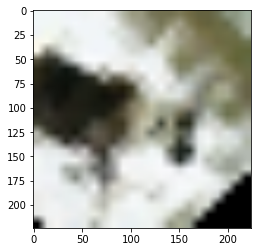

ship


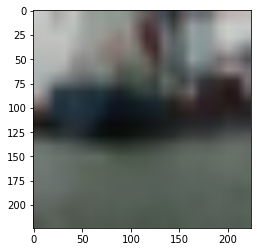

car


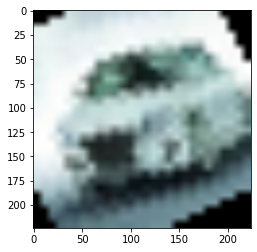

dog


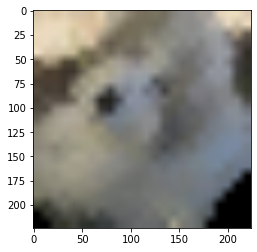

ship


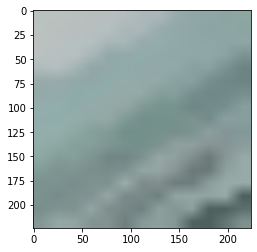

dog


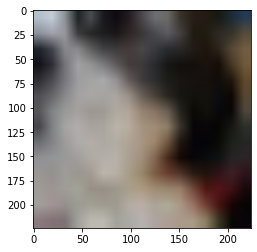

frog


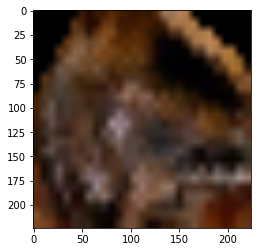

frog


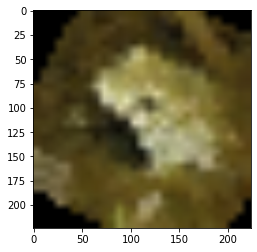

deer


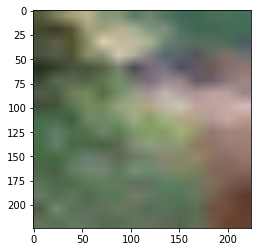

plane


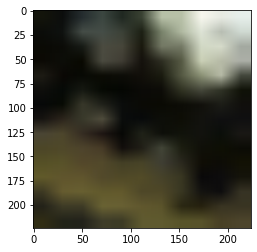

horse


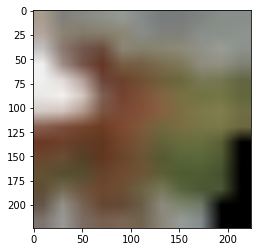

horse


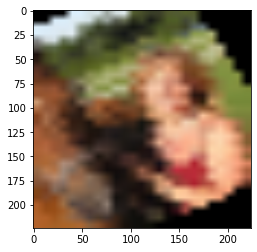

frog


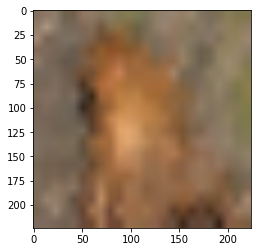

deer


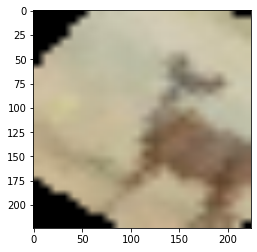

truck


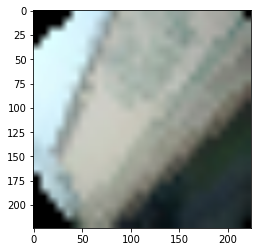

In [4]:
# Explore data
## YOUR CODE HERE ##
show5(train_loader)
show5(valid_loader)
show5(test_loader)

## Build your Neural Network
Using the layers in `torch.nn` (which has been imported as `nn`) and the `torch.nn.functional` module (imported as `F`), construct a neural network based on the parameters of the dataset. 
Feel free to construct a model of any architecture – feedforward, convolutional, or even something more advanced!

In [5]:
## YOUR CODE HERE ##
# I chose the densenet121
model = models.resnet50(pretrained=True)
#print(model)

# Freeze parameters so we don't backprop through them
for param in model.parameters():
    param.requires_grad = False

from collections import OrderedDict
myclassifier = nn.Sequential(OrderedDict([
                          ('fc1', nn.Linear(2048, 768)),
                          ('dropout1', nn.Dropout(0.5)),
                          ('relu', nn.ReLU()),

                          ('fc2', nn.Linear(768, 256)),
                          ('dropout2', nn.Dropout(0.25)),
                          ('relu', nn.ReLU()),                          
                          
                          ('fc3', nn.Linear(256, 10)),#last output for 10 labels
                          ]))
    
model.fc = myclassifier

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Specify a loss function and an optimizer, and instantiate the model.

If you use a less common loss function, please note why you chose that loss function in a comment.

In [6]:
## YOUR CODE HERE ##
# declare a device to train
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)


# I chose the the negative log-like error function and Adam optimizer
# criterion = nn.NLLLoss()
# optimizer = optim.Adam(model.classifier.parameters(), lr=0.003)


criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.fc.parameters(), lr=0.003)

model.to(device)

cuda


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

## Running your Neural Network
Use whatever method you like to train your neural network, and ensure you record the average loss at each epoch. 
Don't forget to use `torch.device()` and the `.to()` method for both your model and your data if you are using GPU!

If you want to print your loss during each epoch, you can use the `enumerate` function and print the loss after a set number of batches. 250 batches works well for most people!

In [7]:
## YOUR CODE HERE ##
epochs = 30
running_loss = 0
min_valid_loss = np.Inf
for epoch in range(epochs):
    for inputs, labels in train_loader:
        # Move input and label tensors to the default device
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        
        logps = model.forward(inputs)
        loss = criterion(logps, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        
    #validation
    valid_loss = 0
    valid_loss_avg = 0
    accuracy = 0
    model.eval()
    with torch.no_grad():
        for inputs, labels in valid_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            logps = model.forward(inputs)
            batch_loss = criterion(logps, labels)

            valid_loss += batch_loss.item()

            # Calculate accuracy
            ps = torch.exp(logps)
            top_p, top_class = ps.topk(1, dim=1)
            equals = top_class == labels.view(*top_class.shape)
            accuracy += torch.mean(equals.type(torch.FloatTensor)).item()

    model.train()
    valid_loss_avg = valid_loss / len(valid_loader)
    print(f"Epoch {epoch+1}/{epochs}.. "
          f"Train loss: {running_loss/len(train_loader):.3f}.. "
          f"Validation loss: {valid_loss_avg:.3f}.. "
          f"Validation accuracy: {accuracy/len(valid_loader):.3f}")
    running_loss = 0
    
    if valid_loss_avg < min_valid_loss:
        print(f"found a better model, saving...")
        torch.save(model.state_dict(), 'model.pt')
        min_valid_loss = valid_loss_avg
        print(f"model saved")

Epoch 1/30.. Train loss: 2.179.. Validation loss: 1.964.. Validation accuracy: 0.335
found a better model, saving...
model saved
Epoch 2/30.. Train loss: 1.858.. Validation loss: 1.714.. Validation accuracy: 0.404
found a better model, saving...
model saved
Epoch 3/30.. Train loss: 1.717.. Validation loss: 1.611.. Validation accuracy: 0.433
found a better model, saving...
model saved
Epoch 4/30.. Train loss: 1.645.. Validation loss: 1.545.. Validation accuracy: 0.451
found a better model, saving...
model saved
Epoch 5/30.. Train loss: 1.597.. Validation loss: 1.503.. Validation accuracy: 0.467
found a better model, saving...
model saved
Epoch 6/30.. Train loss: 1.567.. Validation loss: 1.485.. Validation accuracy: 0.472
found a better model, saving...
model saved
Epoch 7/30.. Train loss: 1.544.. Validation loss: 1.459.. Validation accuracy: 0.481
found a better model, saving...
model saved
Epoch 8/30.. Train loss: 1.523.. Validation loss: 1.435.. Validation accuracy: 0.484
found a bett

Plot the training loss (and validation loss/accuracy, if recorded).

## Testing your model
Using the previously created `DataLoader` for the test set, compute the percentage of correct predictions using the highest probability prediction. 

If your accuracy is over 70%, great work! 
This is a hard task to exceed 70% on.

If your accuracy is under 45%, you'll need to make improvements.
Go back and check your model architecture, loss function, and optimizer to make sure they're appropriate for an image classification task.

In [8]:
## YOUR CODE HERE ##
# load best model
state_dict = torch.load('model.pt')
best_model = model
best_model.load_state_dict(state_dict)
best_model.to(device)


test_loss = 0
accuracy = 0
best_model.eval()
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        logps = model.forward(inputs)
        batch_loss = criterion(logps, labels)

        test_loss += batch_loss.item()

        # Calculate accuracy
        ps = torch.exp(logps)
        top_p, top_class = ps.topk(1, dim=1)
        equals = top_class == labels.view(*top_class.shape)
        accuracy += torch.mean(equals.type(torch.FloatTensor)).item()

print(f"Test loss: {test_loss/len(test_loader):.3f}.. "
      f"Test accuracy: {accuracy/len(test_loader):.3f}")

Test loss: 1.315.. Test accuracy: 0.533


## Saving your model
Using `torch.save`, save your model for future loading.

In [ ]:
## YOUR CODE HERE ##
# I saved the best model while training. This model is saved at epoch #19

## Make a Recommendation

Based on your evaluation, what is your recommendation on whether to build or buy? Explain your reasoning below.

Some things to consider as you formulate your recommendation:
* How does your model compare to Detectocorp's model?
* How does it compare to the far more advanced solutions in the literature? 
* What did you do to get the accuracy you achieved? 
* Is it necessary to improve this accuracy? If so, what sort of work would be involved in improving it?



**Double click this cell to modify it**

Base on the evaluation, I recommend on purchase Detectocorp's solution.
* I set the batch-size=32 for updating the network gradient. I chose the cross-entropy method to calculate an error via softmax function and negative log likehood function.
The Adam optimizer also was applied.

* My model only got the accuracy score around 0.53 on test set and can not win the Detecocorp's model.
I chose the pretrained densenet121 network for transfer learning and replaced the last layer with my classifier.
It took me more than 4 hours to train, but the result was so disappointed. On the first few epochs, the result looked promising but after 20 epochs it can not pass 70% on accuracy score.
Maybe the results will become better if I train in more epochs but I am not sure because the training time was too low and my GPU resources time seems to be not enough.
I think the reason is that the pretrained densenet121 network was not suitable for cifar-10 dataset or my classifier was not constructed well.

* If I have time and GPU resource, I will try the following ways:
<br> 1) Keep the pretrained densenet121 network, add more fullconnect and dropout layers at the last classifier. Maybe the classifer weighs should be initialized to get better result.
<br> 2) Build my own classifier network with many convolutional, pooling, dropout layers.
<br> 3) Try another pretrained network for transfer learning.

## Submit Your Project

When you are finished editing the notebook and are ready to turn it in, simply click the **SUBMIT PROJECT** button in the lower right.

Once you submit your project, we'll review your work and give you feedback if there's anything that you need to work on. If you'd like to see the exact points that your reviewer will check for when looking at your work, you can have a look over the project [rubric](https://review.udacity.com/#!/rubrics/3077/view).